# Inferece demo

In this demo we'll chain the full body parts model with the whisker spot model. More specifically, we'll get the whisker areas croppings from the full body parts model, and send them to the whisker spot model, to get the final whisker spot pattern prediction.

## Arguments

In [1]:
image_path = '../sample_pictures/test_lion.jpg'
body_parts_model_path = '../winners/body_parts/model_finished.pth'
whisker_spot_model_path = '../winners/whisker_spots/model_finished.pth'

# Defaults
force_cpu = False
draw_confidence_threshold = 0.65  # How confident we need to be to draw each box
draw_dpi = 300

## Definitions

In [2]:
# Notebooks are stored in 'notebooks/' which breaks my imports
import sys
sys.path.insert(0, '..')

import numpy as np
import time
import torch
from PIL import Image
import torchvision
from models import detection
from utils import draw_boxes

from matplotlib.pyplot import imshow, show
import matplotlib

In [3]:
matplotlib.rcParams['figure.dpi'] = draw_dpi

to_tensor = torchvision.transforms.ToTensor()
convert_to_pil = torchvision.transforms.ToPILImage()

@torch.no_grad()
def load_and_run_model(pil_image, model_path, force_cpu):
    device = 'cuda' if torch.has_cuda and not force_cpu else 'cpu'
    print(f"Running inference on {device} device")

    print('Loading image... ', end='', flush=True)
    image = to_tensor(pil_image).to(device)
    print('Done.')

    print('Loading checkpoint from hardrive... ', end='', flush=True)
    checkpoint = torch.load(model_path, map_location=device)
    label_names = checkpoint['label_names']
    print('Done.')

    print('Building model and loading checkpoint into it... ', end='', flush=True)
    model = detection.fasterrcnn_resnet50_fpn(
        num_classes=len(label_names) + 1, pretrained_backbone=False
    )
    model.to(device)

    model.load_state_dict(checkpoint['model'])
    model.eval()
    print('Done.')

    print('Running image through model... ', end='', flush=True)
    tic = time.time()
    outputs = model([image])[0]  # We index 0 because we are using batch size 1
    toc = time.time()
    print(f'Done in {toc - tic:.2f} seconds!')

    print(f'Drawing image... ')
    scores = outputs['scores']
    top_scores_filter = scores > draw_confidence_threshold
    top_scores = scores[top_scores_filter]
    top_boxes = outputs['boxes'][top_scores_filter]
    top_labels = outputs['labels'][top_scores_filter]
    if len(top_scores) > 0:
        image_with_boxes = draw_boxes(
            image.cpu(), top_boxes, top_labels.cpu(), label_names, scores, vert_size=500
        )
    else:
        print("The model didn't find any object it feels confident about enough to draw")
        return
    imshow(np.asarray(convert_to_pil(image_with_boxes)))
    show()
    return outputs

## Run body parts model

Running inference on cuda device
Loading image... Done.
Loading checkpoint from hardrive... Done.
Building model and loading checkpoint into it... Done.
Running image through model... Done in 0.17 seconds!
Drawing image... 


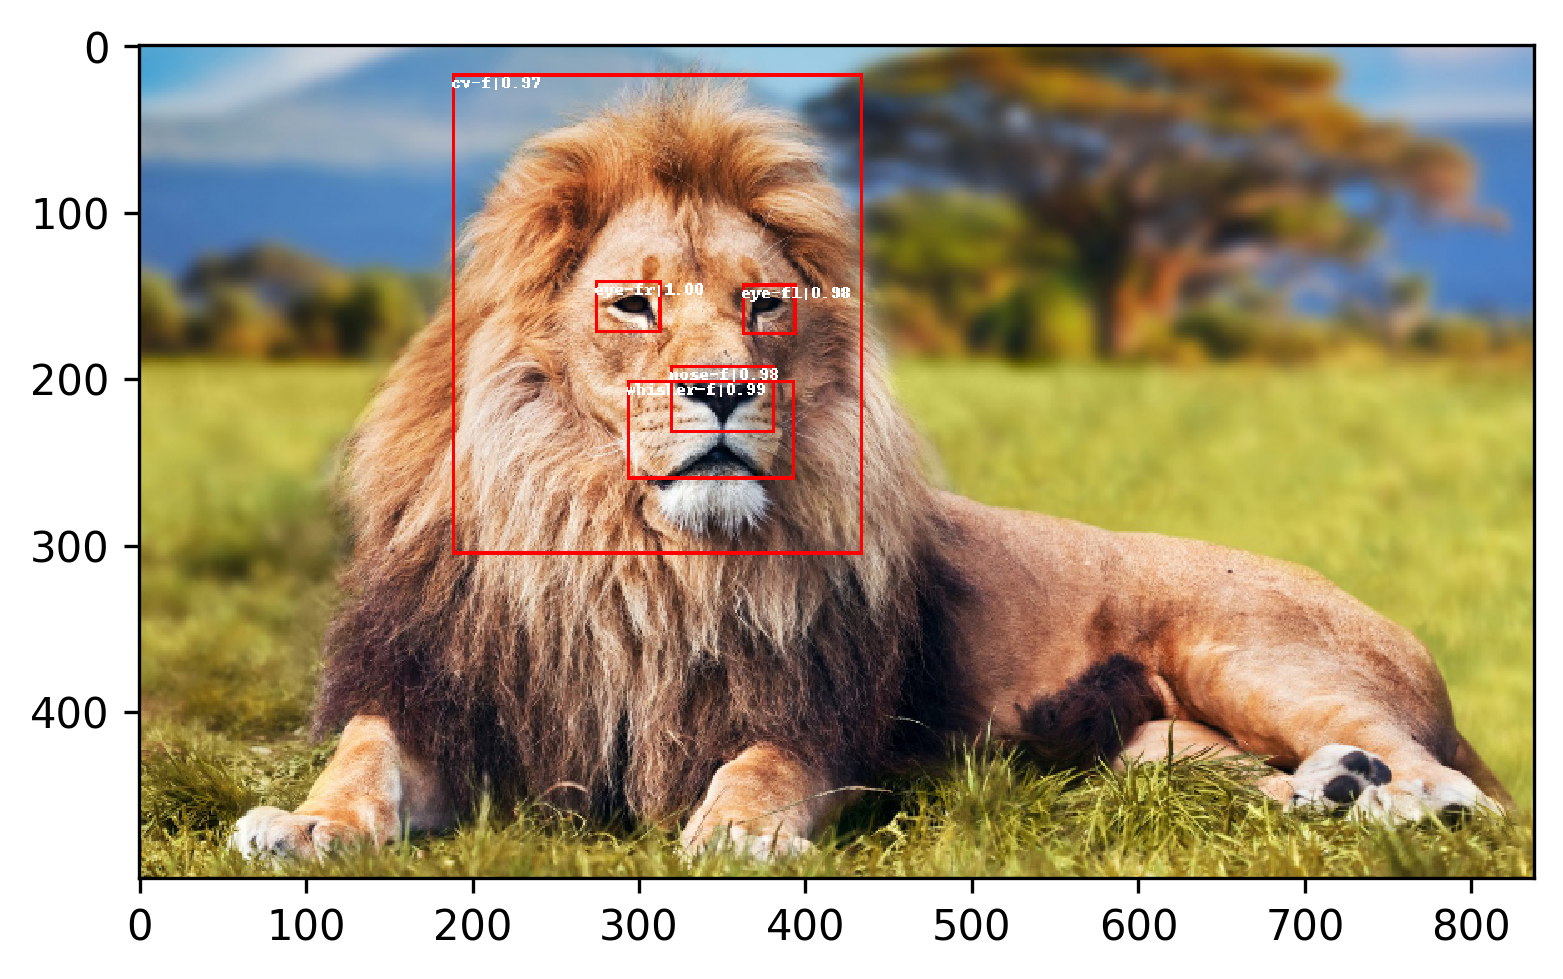

In [4]:
input_image = Image.open(image_path).convert('RGB')
body_parts_predictions = load_and_run_model(input_image, body_parts_model_path, force_cpu)

In [5]:
# Our model outputs its predictions in a dict with a 'boxes', 'labels' and 'scores' keys:
body_parts_predictions

{'boxes': tensor([[523.1883, 270.2926, 598.4796, 329.9466],
         [560.4652, 384.7947, 750.1150, 497.7932],
         [609.3375, 367.1972, 727.8204, 444.2526],
         [691.9811, 272.8602, 752.2468, 331.2870],
         [359.6852,  33.0656, 828.7993, 583.5533],
         [336.2988,  71.1315, 650.8803, 528.2864],
         [575.0757, 386.9340, 745.5440, 481.9645]], device='cuda:0'),
 'labels': tensor([19, 29, 24, 18,  3,  2,  3], device='cuda:0'),
 'scores': tensor([0.9972, 0.9949, 0.9772, 0.9760, 0.9651, 0.5085, 0.0834],
        device='cuda:0')}

## Crop whisker areas

whisker-f


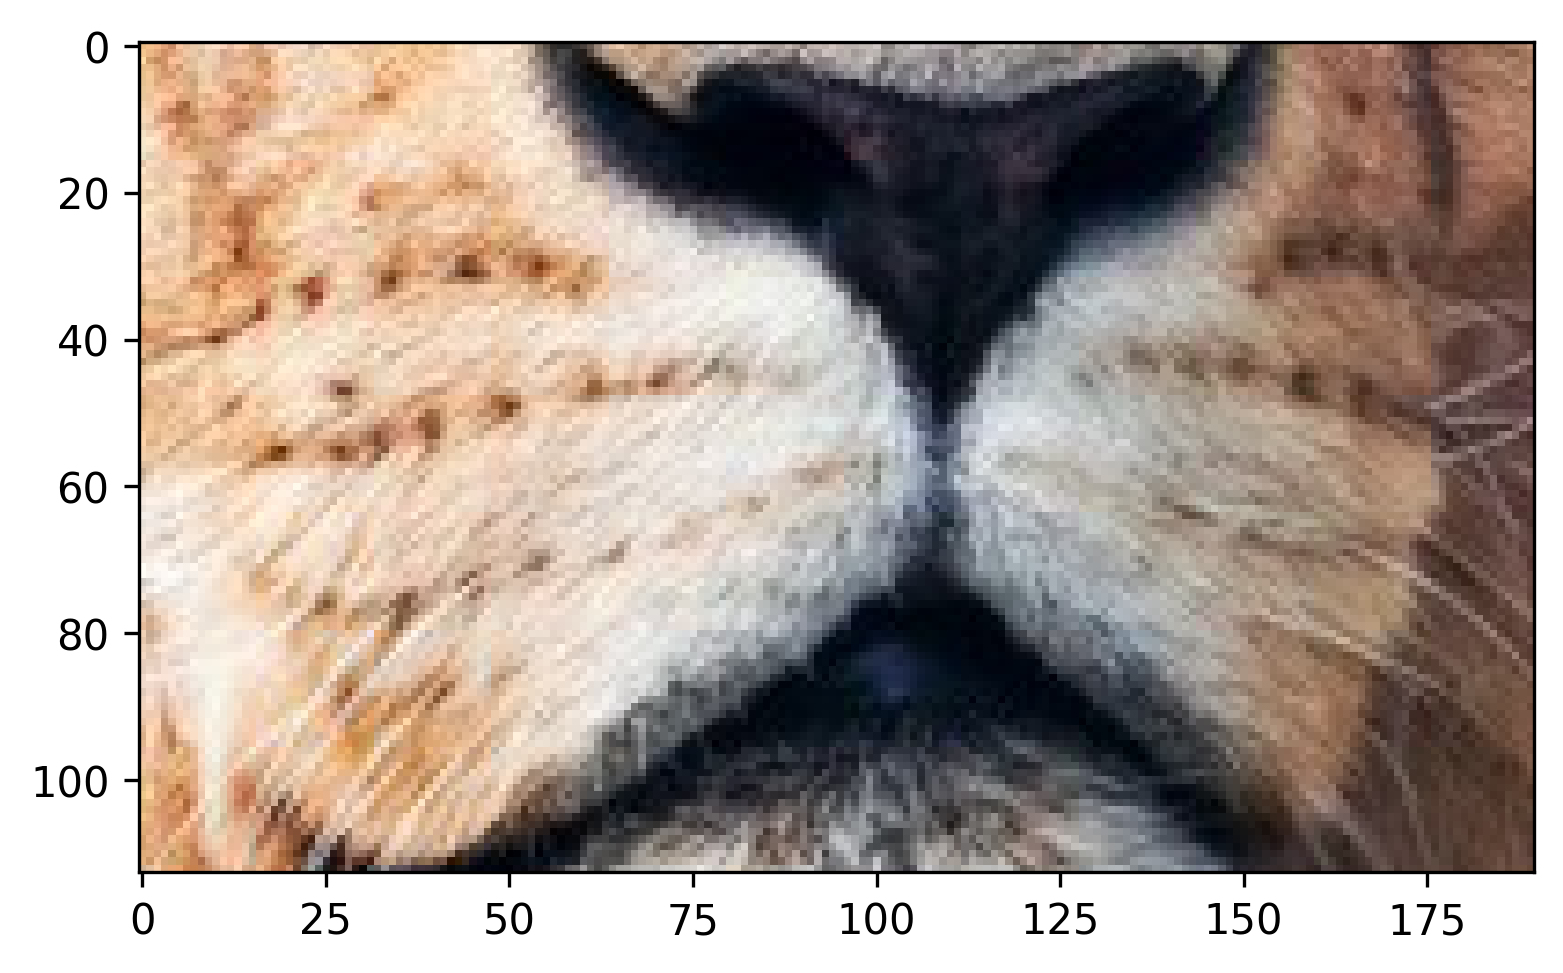

In [6]:
labels_which_correspond_to_whisker_areas = {
    27: 'whisker-dl',
    28: 'whisker-dr',
    29: 'whisker-f',
    30: 'whisker-sl',
    31: 'whisker-sr'
}

whisker_area_crops = []
for idx, label in enumerate(body_parts_predictions['labels']):
    label = int(label)
    if label in labels_which_correspond_to_whisker_areas.keys():
        box = body_parts_predictions['boxes'][idx]
        cropped_image = input_image.crop(
                (int(box[0]), int(box[1]), int(box[2]), int(box[3]))
        )
        whisker_area_crops.append(cropped_image)
        print(labels_which_correspond_to_whisker_areas[label])
        imshow(cropped_image)
        show()

## Run whisker spots model

Running inference on cuda device
Loading image... Done.
Loading checkpoint from hardrive... Done.
Building model and loading checkpoint into it... Done.
Running image through model... Done in 0.08 seconds!
Drawing image... 


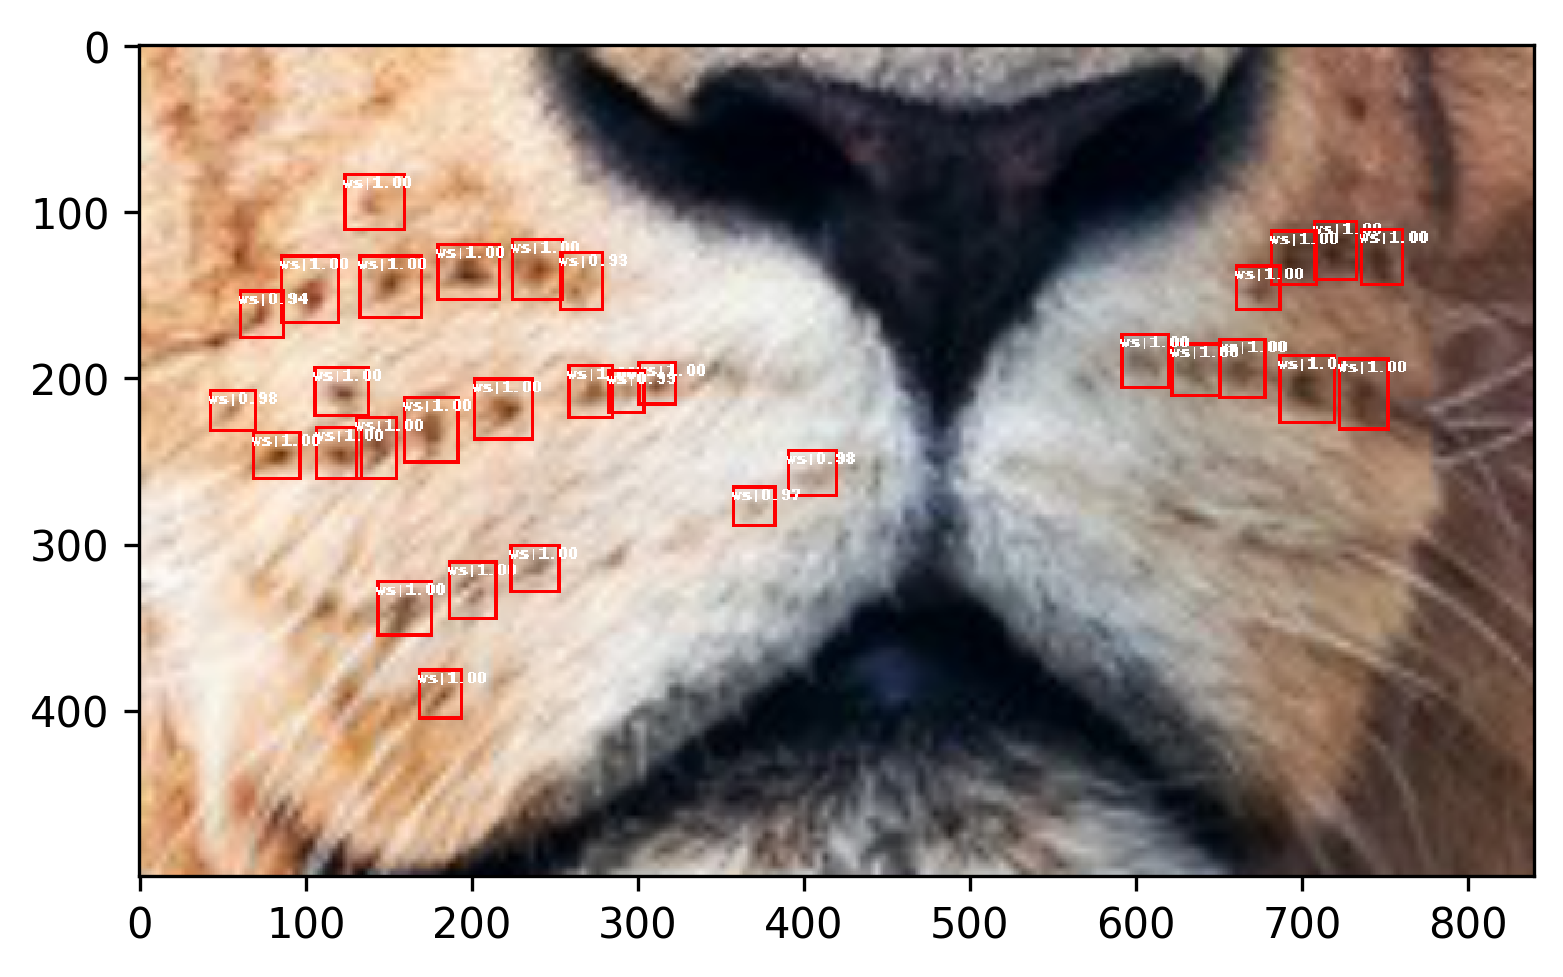

In [7]:
# We are being really inefficient reloading the model on each step,
# but it doesn't really change much.
for whisker_area_crop in whisker_area_crops:
    whiskers_predictions = load_and_run_model(whisker_area_crop, whisker_spot_model_path, force_cpu)

In [8]:
# Our model outputs its predictions in a dict with a 'boxes', 'labels' and 'scores' keys:
whiskers_predictions

{'boxes': tensor([[ 40.6472,  26.9239,  49.0459,  34.7587],
         [155.1034,  42.1533, 162.8428,  51.3830],
         [ 50.7963,  26.3615,  57.6938,  34.6636],
         [ 29.9495,  28.5917,  38.5309,  37.2271],
         [159.8140,  23.9408, 165.8751,  31.9259],
         [147.1004,  39.8730, 153.4463,  48.0334],
         [ 36.0711,  47.7959,  43.4919,  56.9512],
         [ 45.6197,  45.2428,  53.6478,  53.5925],
         [140.3879,  40.5288, 147.1491,  47.8728],
         [ 42.0560,  70.2402,  48.7287,  78.1078],
         [ 19.2894,  28.5457,  27.3095,  37.9581],
         [154.0005,  25.1190, 160.2367,  32.5859],
         [ 24.1623,  51.7945,  30.4941,  59.1814],
         [ 50.5197,  67.8096,  57.2264,  74.5103],
         [166.1414,  24.9736, 172.1629,  32.7608],
         [149.3517,  29.8784, 155.3651,  36.0362],
         [ 15.4291,  52.5676,  21.9856,  59.1167],
         [ 23.7947,  43.6932,  31.1899,  50.4276],
         [163.2789,  42.6048, 170.1639,  52.2940],
         [ 38.0256,  8